In [1]:
import torch
import pandas as pd
from pathlib import Path
import numpy as np
import pandas as pd
import random
from glob import glob
import sklearn

from tqdm.autonotebook import tqdm
from sklearn.metrics import average_precision_score, roc_auc_score
from pathlib import Path

#set up plotting
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for large visuals
%config InlineBackend.figure_format = 'retina'

# opensoundscape transfer learning tools
from opensoundscape.ml.shallow_classifier import MLPClassifier, quick_fit, fit_classifier_on_embeddings


/tmp/ipykernel_363587/121805284.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
from sklearn.model_selection import train_test_split
from opensoundscape import BoxedAnnotations, CNN

In [3]:
n_samples_per_class = 1000
filename = 'Shallow_classifier_perch_resample'

In [4]:
metadata = pd.read_csv('./data/metadata.csv')
metadata.head()

,Unnamed: 0,Begin Time (s),End Time (s),Low Freq (Hz),High Freq (Hz),Species,Conf,Call_type,Filename,SiteHab,RecordingSched,RecorderName,DP,SoundFile,SoundFile_path,Split,Raven_path
0,0,0.763354,3.078034,2854.369,5965.410,Philepitta_castanea,NaN,NaN,AGN_A-AGN04_20230429_054000.txt,AGN,A,AGN_A-AGN04,AGN04,AGN_A-AGN04_20230429_054000.WAV,/mnt/class_data/group1_bioacoustics/sheila/cv4...,validation,/mnt/class_data/group1_bioacoustics/sheila/Pro...
1,1,6.588949,9.475884,2571.297,5451.150,Philepitta_castanea,NaN,NaN,AGN_A-AGN04_20230429_054000.txt,AGN,A,AGN_A-AGN04,AGN04,AGN_A-AGN04_20230429_054000.WAV,/mnt/class_data/group1_bioacoustics/sheila/cv4...,validation,/mnt/class_data/group1_bioacoustics/sheila/Pro...
2,2,10.434780,12.523959,3085.557,5348.299,Philepitta_castanea,NaN,NaN,AGN_A-AGN04_20230429_054000.txt,AGN,A,AGN_A-AGN04,AGN04,AGN_A-AGN04_20230429_054000.WAV,/mnt/class_data/group1_bioacoustics/sheila/cv4...,validation,/mnt/class_data/group1_bioacoustics/sheila/Pro...
3,3,14.854197,15.436757,3085.557,5862.558,Philepitta_castanea,NaN,NaN,AGN_A-AGN04_20230429_054000.txt,AGN,A,AGN_A-AGN04,AGN04,AGN_A-AGN04_20230429_054000.WAV,/mnt/class_data/group1_bioacoustics/sheila/cv4...,validation,/mnt/class_data/group1_bioacoustics/sheila/Pro...
4,4,55.578030,59.479764,2621.359,5475.728,Philepitta_castanea,NaN,NaN,AGN_A-AGN04_20230429_054000.txt,AGN,A,AGN_A-AGN04,AGN04,AGN_A-AGN04_20230429_054000.WAV,/mnt/class_data/group1_bioacoustics/sheila/cv4...,validation,/mnt/class_data/group1_bioacoustics/sheila/Pro...


In [5]:
val_metadata=metadata[metadata["Split"]=="validation"]
train_metadata=metadata[metadata["Split"]=="train"]
test_metadata=metadata[metadata["Split"]=="test"]

In [6]:
val_metadata=val_metadata.reset_index()
train_metadata=train_metadata.reset_index()
test_metadata=test_metadata.reset_index()

In [ ]:
# assume we have a list of raven annotation files and corresponding audio files
# load the annotations into OpenSoundscape
raven_file_paths = val_metadata['Raven_path']
audio_file_paths = val_metadata['SoundFile_path']
val_annotations = BoxedAnnotations.from_raven_files(raven_file_paths,'species',audio_file_paths)

raven_file_paths = train_metadata['Raven_path']
audio_file_paths = train_metadata['SoundFile_path']
train_annotations = BoxedAnnotations.from_raven_files(raven_file_paths,'species',audio_file_paths)

raven_file_paths = test_metadata['Raven_path']
audio_file_paths = test_metadata['SoundFile_path']
test_annotations = BoxedAnnotations.from_raven_files(raven_file_paths,'species',audio_file_paths)

In [ ]:
# Create the table with a dataframe
conversion_table = pd.DataFrame(
    {'original':['Eulemur_albifrons', 'Eulemur_fulvus'],
     'new':['Eulemur_sp', 'Eulemur_sp']}
)

# Or create the table in its own spreadsheet
#conversion_table = pd.read_csv('my_conversion_filename_here.csv')

conversion_table

,original,new
0,Eulemur_albifrons,Eulemur_sp
1,Eulemur_fulvus,Eulemur_sp


In [ ]:
#correct annotations in each of the splits
val_annotations_corrected = val_annotations.convert_labels(conversion_table)
val_annotations_corrected.audio_files = val_annotations_corrected.df['audio_file'].values #workaround for issue #872
val_annotations_corrected.df.head()

train_annotations_corrected = train_annotations.convert_labels(conversion_table)
train_annotations_corrected.audio_files = train_annotations_corrected.df['audio_file'].values #workaround for issue #872
train_annotations_corrected.df.head()

test_annotations_corrected = test_annotations.convert_labels(conversion_table)
test_annotations_corrected.audio_files = test_annotations_corrected.df['audio_file'].values #workaround for issue #872
test_annotations_corrected.df.head()


,audio_file,annotation_file,annotation,start_time,end_time,low_f,high_f,Delta Time (s),Avg Power Density (dB FS/Hz),View,Channel,Conf,Call_type,Delta Freq (Hz),Selection
0,/mnt/class_data/group1_bioacoustics/sheila/cv4...,/mnt/class_data/group1_bioacoustics/sheila/Pro...,Hypsipetes_madagascariensis,54.905264,56.190913,1968.454,5223.975,NaN,NaN,Spectrogram 1,1,0.9,call,NaN,1
1,/mnt/class_data/group1_bioacoustics/sheila/cv4...,/mnt/class_data/group1_bioacoustics/sheila/Pro...,Dicrurus_forficatus,4.943181,11.329778,659.794,5690.722,NaN,NaN,Spectrogram 1,1,0.9,call,NaN,1
2,/mnt/class_data/group1_bioacoustics/sheila/cv4...,/mnt/class_data/group1_bioacoustics/sheila/Pro...,Dicrurus_forficatus,13.011363,15.447871,551.700,5773.196,NaN,NaN,Spectrogram 1,1,0.9,call,NaN,2
3,/mnt/class_data/group1_bioacoustics/sheila/cv4...,/mnt/class_data/group1_bioacoustics/sheila/Pro...,Dicrurus_forficatus,17.215908,19.923388,494.845,5773.196,NaN,NaN,Spectrogram 1,1,0.9,call,NaN,3
4,/mnt/class_data/group1_bioacoustics/sheila/cv4...,/mnt/class_data/group1_bioacoustics/sheila/Pro...,Dicrurus_forficatus,24.282540,29.043458,742.268,6103.093,NaN,NaN,Spectrogram 1,1,0.9,call,NaN,4


In [ ]:
# pick classes to train the model on. These should occur in the annotated data
class_list = ['Hypsipetes_madagascariensis','Copsychus_albospecularis','Coracopsis_nigra','Dicrurus_forficatus','Coua_caerulea','Zosterops_maderaspatanus','Eurystomus_glaucurus','Agapornis_canus','Saxicola_torquatus','Cyanolanius_madagascarinus','Leptopterus_chabert','Nesoenas_picturatus','Coua_reynaudii','Ceblepyris_cinereus','Neodrepanis_coruscans','Philepitta_castanea','Eulemur_sp','Coua_cristata','Treron_australis']

In [ ]:
# create labels for fixed-duration (5 second) clips
val_labels = val_annotations_corrected.clip_labels(
  clip_duration=5,
  clip_overlap=0,
  min_label_overlap=0.25,
  class_subset=class_list
)

train_labels = train_annotations_corrected.clip_labels(
  clip_duration=5,
  clip_overlap=0,
  min_label_overlap=0.25,
  class_subset=class_list
)

test_labels = test_annotations_corrected.clip_labels(
  clip_duration=5,
  clip_overlap=0,
  min_label_overlap=0.25,
  class_subset=class_list
)

In [ ]:
train_labels_resampled = opensoundscape.data_selection.resample(train_labels,n_samples_per_class = n_samples_per_class, downsample = False,upsample = True)

In [ ]:
from bioacoustics_model_zoo import Perch

In [ ]:
perch_model = Perch()

2025-01-22 16:39:36.088664: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-22 16:39:36.088703: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-22 16:39:36.089638: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-22 16:39:36.094669: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-22 16:39:38.073559: I exter

In [ ]:
emb_train = perch_model.embed(train_labels_resampled, return_dfs=False, batch_size=128, num_workers=0)
emb_val = perch_model.embed(val_labels, return_dfs=False, batch_size=128, num_workers=0)

  0%|          | 0/80 [00:00<?, ?it/s]

2025-01-22 16:39:46.131597: I external/local_xla/xla/service/service.cc:168] XLA service 0x620779060680 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-22 16:39:46.131647: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2025-01-22 16:39:46.365775: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-22 16:39:46.373947: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator jax2tf_infer_fn_/assert_equal_1/Assert/AssertGuard/Assert
2025-01-22 16:39:46.949570: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-01-22 16:39:49.978677: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng4{} for conv (f32[128,160,500,1]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,160,755

  0%|          | 0/12 [00:00<?, ?it/s]

In [ ]:
# pick classes to train the model on. These should occur in the annotated data
class_list = ['Hypsipetes_madagascariensis','Copsychus_albospecularis','Coracopsis_nigra','Dicrurus_forficatus','Coua_caerulea','Zosterops_maderaspatanus','Eurystomus_glaucurus','Agapornis_canus','Saxicola_torquatus','Cyanolanius_madagascarinus','Leptopterus_chabert','Nesoenas_picturatus','Coua_reynaudii','Ceblepyris_cinereus','Neodrepanis_coruscans','Philepitta_castanea','Eulemur_sp','Coua_cristata','Treron_australis']



In [ ]:
perch_model.change_classes(class_list) # replace fc layer with 1-output layer
quick_fit(perch_model.network, emb_train, train_labels_resampled.values, emb_val, val_labels.values,steps=1000)

Epoch 100/1000, Loss: 0.10480885207653046, Val Loss: 0.10438428074121475
val AU ROC: 0.129
val MAP: 0.129


/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning

Epoch 200/1000, Loss: 0.06628761440515518, Val Loss: 0.06689335405826569
val AU ROC: 0.182
val MAP: 0.182


/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning

Epoch 300/1000, Loss: 0.053370654582977295, Val Loss: 0.05457117781043053
val AU ROC: 0.231
val MAP: 0.231


/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning

Epoch 400/1000, Loss: 0.04652875289320946, Val Loss: 0.04830361530184746
val AU ROC: 0.274
val MAP: 0.274


/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning

Epoch 500/1000, Loss: 0.04213116690516472, Val Loss: 0.04450799524784088
val AU ROC: 0.307
val MAP: 0.307


/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning

Epoch 600/1000, Loss: 0.03899798542261124, Val Loss: 0.041961200535297394
val AU ROC: 0.335
val MAP: 0.335


/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning

Epoch 700/1000, Loss: 0.036621350795030594, Val Loss: 0.04012827202677727
val AU ROC: 0.356
val MAP: 0.356


/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning

Epoch 800/1000, Loss: 0.034737251698970795, Val Loss: 0.03874135762453079
val AU ROC: 0.376
val MAP: 0.376


/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning

Epoch 900/1000, Loss: 0.0331931971013546, Val Loss: 0.03765331208705902
val AU ROC: 0.387
val MAP: 0.387


/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning

Epoch 1000/1000, Loss: 0.03189621493220329, Val Loss: 0.03677797317504883
val AU ROC: 0.398
val MAP: 0.398
Training complete


/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning

In [ ]:
val_labels

Hypsipetes_madagascariensis  \
file                                               start_time end_time                                
/mnt/class_data/group1_bioacoustics/sheila/cv4e... 0.0        2.0                             False   
                                                   2.0        4.0                             False   
                                                   4.0        6.0                             False   
                                                   6.0        8.0                             False   
                                                   8.0        10.0                            False   
...                                                                                             ...   
/mnt/class_data/group1_bioacoustics/sheila/cv4e... 50.0       52.0                             True   
                                                   52.0       54.0                             True   
                                                   54.0       56.0                             True   
                                                   56.0       58.0                             True   
                                                   58.0       60.0                             True   

                                                                        Copsychus_albospecularis  \
file                                               start_time end_time                             
/mnt/class_data/group1_bioacoustics/sheila/cv4e... 0.0        2.0                          False   
                                                   2.0        4.0                          False   
                                                   4.0        6.0                          False   
                                                   6.0        8.0                          False   
                                                   8.0        10.0                         False   
...                                                                                          ...   
/mnt/class_data/group1_bioacoustics/sheila/cv4e... 50.0       52.0                         False   
                                                   52.0       54.0                         False   
                                                   54.0       56.0                         False   
                                                   56.0       58.0                         False   
                                                   58.0       60.0                         False   

                                                                        Coracopsis_nigra  \
file                                               start_time end_time                     
/mnt/class_data/group1_bioacoustics/sheila/cv4e... 0.0        2.0                  False   
                                                   2.0        4.0                  False   
                                                   4.0        6.0                  False   
                                                   6.0        8.0                  False   
                                                   8.0        10.0                 False   
...                                                                                  ...   
/mnt/class_data/group1_bioacoustics/sheila/cv4e... 50.0       52.0                 False   
                                                   52.0       54.0                 False   
                                                   54.0       56.0                 False   
                                                   56.0       58.0                 False   
                                                   58.0       60.0                 False   

                                                                        Dicrurus_forficatus  \
file                                               start_time end_time                        
/mnt/class_data/group1_bioacoustics/sheila/c

In [ ]:
# make predictions by passing the embeddings through the classifier
preds = perch_model.network(torch.tensor(emb_val).float()).detach().numpy()

preds = pd.DataFrame(preds,index=val_labels.index,columns=val_labels.columns)
preds

Hypsipetes_madagascariensis  \
file                                               start_time end_time                                
/mnt/class_data/group1_bioacoustics/sheila/cv4e... 0.0        2.0                         -3.025625   
                                                   2.0        4.0                          0.031188   
                                                   4.0        6.0                         -0.921344   
                                                   6.0        8.0                         -1.324998   
                                                   8.0        10.0                        -1.779422   
...                                                                                             ...   
/mnt/class_data/group1_bioacoustics/sheila/cv4e... 50.0       52.0                        -0.878390   
                                                   52.0       54.0                        -1.378786   
                                                   54.0       56.0                        -1.183426   
                                                   56.0       58.0                        -1.542624   
                                                   58.0       60.0                        -0.693589   

                                                                        Copsychus_albospecularis  \
file                                               start_time end_time                             
/mnt/class_data/group1_bioacoustics/sheila/cv4e... 0.0        2.0                      -4.426260   
                                                   2.0        4.0                      -3.878440   
                                                   4.0        6.0                      -4.075803   
                                                   6.0        8.0                      -4.513834   
                                                   8.0        10.0                     -4.789394   
...                                                                                          ...   
/mnt/class_data/group1_bioacoustics/sheila/cv4e... 50.0       52.0                     -5.083760   
                                                   52.0       54.0                     -4.140664   
                                                   54.0       56.0                     -4.993975   
                                                   56.0       58.0                     -3.131606   
                                                   58.0       60.0                     -4.135436   

                                                                        Coracopsis_nigra  \
file                                               start_time end_time                     
/mnt/class_data/group1_bioacoustics/sheila/cv4e... 0.0        2.0              -4.930188   
                                                   2.0        4.0              -4.043409   
                                                   4.0        6.0              -3.914194   
                                                   6.0        8.0              -4.289582   
                                                   8.0        10.0             -5.065327   
...                                                                                  ...   
/mnt/class_data/group1_bioacoustics/sheila/cv4e... 50.0       52.0             -4.976112   
                                                   52.0       54.0             -5.170516   
                                                   54.0       56.0             -5.306009   
                                                   56.0       58.0             -5.357110   
                                                   58.0       60.0             -5.085470   

                                                                        Dicrurus_forficatus  \
file                                               start_time end_time                        
/mnt/class_data/group1_bioacoustics/sheila/c

In [ ]:

# plot histogram of scores for positive and negative clips
plt.hist(preds[val_labels==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[val_labels==False],bins=20,alpha=0.5,label='negatives')
plt.legend()
plt.semilogy()

# calculate the area under the ROC score
roc_auc_score(val_labels.values,preds,average=None)

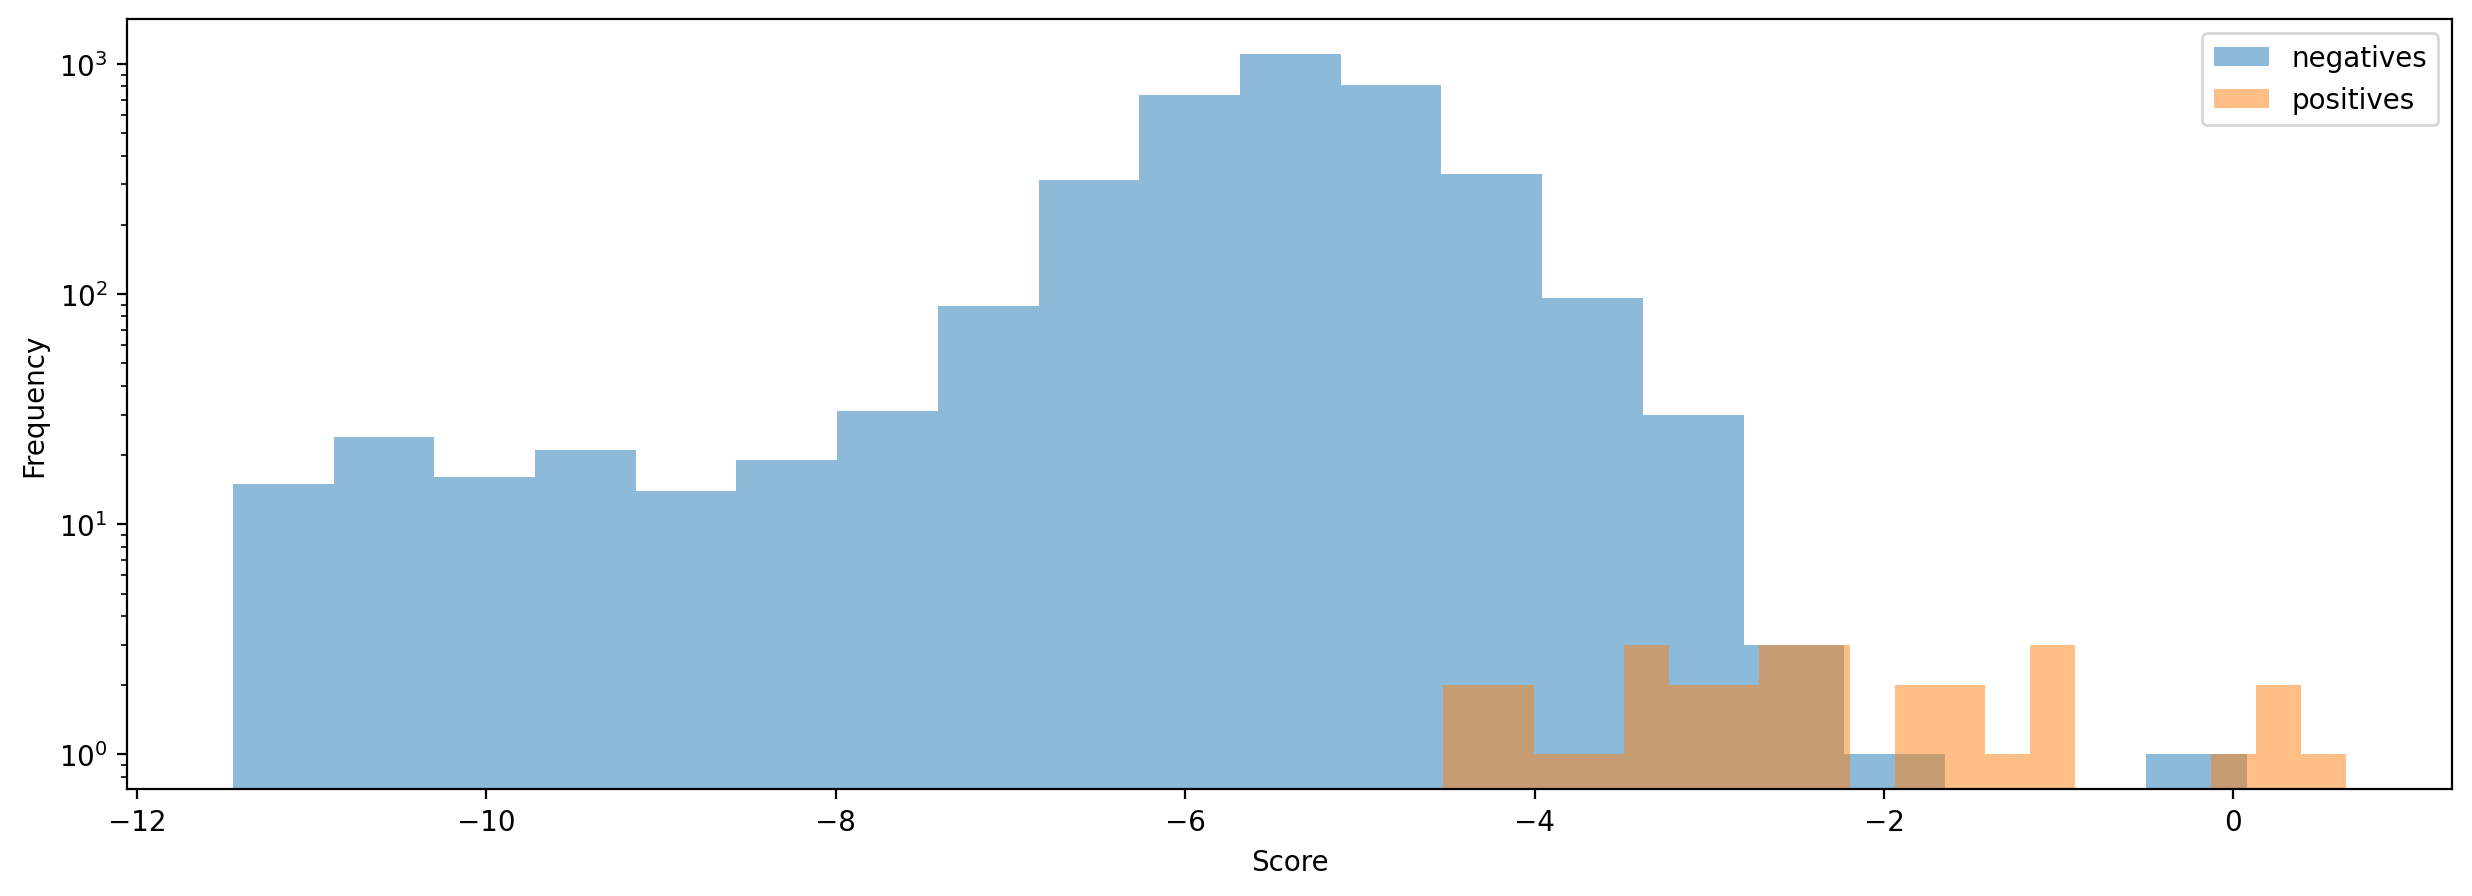

In [ ]:
histspecies = 'Coua_caerulea'
# Filter
df_Pos = preds[val_labels==True]
df_NOT = preds[val_labels==False]
# Plot histograms
plt.hist(df_NOT[histspecies],bins=20,alpha=0.5,label='negatives')
plt.hist(df_Pos[histspecies],bins=20,alpha=0.5,label='positives')
# Add a legend and labels
plt.legend()
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.semilogy()
# Show the plot
plt.show()

In [ ]:
avprecscore_auroc_by_sp = pd.DataFrame(columns=['species', 'avg_precision_score','auroc_score'])
for species in class_list:
    avgscore = sklearn.metrics.average_precision_score(val_labels [species],preds [species])
    auroc = sklearn.metrics.roc_auc_score(val_labels[species],preds [species])
    new_row = pd.DataFrame({'species': [species], 'avg_precision_score': [avgscore], 'auroc_score': [auroc]})
    avprecscore_auroc_by_sp = pd.concat([avprecscore_auroc_by_sp, new_row], ignore_index=True)

avprecscore_auroc_by_sp

/tmp/ipykernel_344921/3174497413.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  avprecscore_auroc_by_sp = pd.concat([avprecscore_auroc_by_sp, new_row], ignore_index=True)
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarni

,species,avg_precision_score,auroc_score
0,Hypsipetes_madagascariensis,0.845089,0.931286
1,Copsychus_albospecularis,0.773054,0.984577
2,Coracopsis_nigra,0.825614,0.979247
3,Dicrurus_forficatus,0.865447,0.977678
4,Coua_caerulea,0.665103,0.987261
5,Zosterops_maderaspatanus,0.443199,0.963122
6,Eurystomus_glaucurus,0.968898,0.999809
7,Agapornis_canus,0.090217,0.903825
8,Saxicola_torquatus,0.789613,0.996377
9,Cyanolanius_madagascarinus,0.004945,0.548277


In [ ]:
avprecscore_auroc_by_sp.to_csv(f'/mnt/class_data/group1_bioacoustics/sheila/results/{filename}.csv')

: 